In [166]:
#%%
# basic
import os 
import re 
import warnings
import numpy as np 
import pandas as pd 
import datetime as dt
import statsmodels.api as sm 
from pandas_datareader import data as pdr
warnings.filterwarnings("ignore")


# matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker


In [167]:
Event_Data  = pd.read_excel(r'/Users/chen-lichiang/Desktop/Rating Agency/Analysis_Detail_Moody_Data.xlsx')
ticker_list = list( set(Event_Data['ticker'].to_list()) )
print(ticker_list)

['BRK.B', 'HIG', 'TSN', 'RTX', 'EXPE', 'LEG', 'URI', 'EXC', 'BBWI', 'PNW', 'ZBRA', 'FE', 'GL', 'TXN', 'FTNT', 'CME', 'UNM', 'RF', 'VTR', 'IPG', 'NLOK', 'ETR', 'F', 'SYY', 'CARR', 'YUM', 'EOG', 'KR', 'LMT', 'TDG', 'HRL', 'XYL', 'ALB', 'TPR', 'MMC', 'CFG', 'HST', 'BIO', 'PG', 'SYK', 'NWL', 'QRVO', 'MDT', 'PHM', 'NLSN', 'AMCR', 'ADM', 'FOXA', 'KMI', 'GLW', 'PTC', 'AEE', 'WYNN', 'ESS', 'APD', 'DLTR', 'PEAK', 'STE', 'STZ', 'FRT', 'GNRC', 'ED', 'PSX', 'COF', 'EQR', 'TFC', 'NRG', 'UA', 'ABC', 'AXP', 'DTE', 'PYPL', 'OKE', 'DOW', 'AMZN', 'DFS', 'COP', 'SRE', 'FTV', 'PBCT', 'CMS', 'PM', 'TAP', 'MAA', 'ATO', 'NFLX', 'WMT', 'DG', 'GE', 'LNC', 'WDC', 'SEE', 'PRU', 'RE', 'TEL', 'BEN', 'BSX', 'LDOS', 'D', 'ALK', 'BA', 'LNT', 'PEG', 'GOOGL', 'EQIX', 'GIS', 'LEN', 'BKNG', 'NOW', 'BLK', 'IR', 'JNJ', 'MAR', 'LHX', 'HBAN', 'FBHS', 'ALL', 'C', 'MCK', 'GILD', 'LOW', 'MCHP', 'LLY', 'CVS', 'JPM', 'MU', 'AMGN', 'HON', 'UHS', 'CZR', 'PXD', 'CAH', 'IT', 'TWTR', 'DISCA', 'KEYS', 'HBI', 'AWK', 'OMC', 'RJF', 'HUM',

In [168]:

class Ken_French_Library():
    """
    Fama/French 3 Factors [Weekly]
    Fama/French 3 Factors [Daily]
    """

    def __init__(self,start,periods):

        self.start = start 
        self.periods = periods
    
    def get_data(self):

        research_factors = pdr.DataReader('F-F_Research_Data_Factors_'+str(self.periods),
                                      'famafrench', start=self.start)[0]
        momentum_factor = pdr.DataReader('F-F_Momentum_Factor_daily',
                                     'famafrench', start=self.start)[0]

        five_factors = research_factors.join(momentum_factor).dropna()
        five_factors /= 100.
        five_factors.index = five_factors.index.tz_localize('utc')

        five_factors.columns = five_factors.columns.str.strip()

        self.five_factors = pd.DataFrame(five_factors)
        self.five_factors = self.five_factors.reset_index()
        self.five_factors['Date'] = self.five_factors.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.five_factors.index   = self.five_factors['Date']
        self.five_factors = self.five_factors.drop(['Date'],axis=1)
        
        return self.five_factors
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        

    def __len__(self):
        return self.five_factors.shape[0]


Fama_French =  Ken_French_Library(start=dt.datetime(1995,1,1),periods='Daily')
FF_DF       =  Fama_French.get_data()
FF_DF

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
1995-01-03,-0.0026,-0.0097,0.0093,0.0002,-0.0117
1995-01-04,0.0033,-0.0031,0.0049,0.0002,-0.0058
1995-01-05,-0.0005,0.0005,0.0006,0.0002,-0.0038
1995-01-06,0.0018,0.0001,0.0012,0.0002,0.0001
1995-01-09,0.0008,0.0002,0.0014,0.0002,-0.0027
...,...,...,...,...,...
2021-06-24,0.0068,0.0062,0.0023,0.0000,0.0071
2021-06-25,0.0032,-0.0068,0.0046,0.0000,-0.0058
2021-06-28,0.0023,-0.0048,-0.0159,0.0000,0.0011


In [169]:
def Fama_French_Predict_Return(Regression_Df):

    
    def OLS_Linear_Regression(y,x,print=None):

        # linear Regression
        x     = sm.add_constant(x)
        model = sm.OLS(y,x)
        res   = model.fit()

        # Print Summary
        if print :
            print(res.summary())

        return res.params


    # Famma_French_Predict_Return . 
    x = Regression_Df[['Mkt-RF','SMB','HML']].values 
    x = sm.add_constant(x)
    y = Regression_Df['Returns'].values
    parameters   = OLS_Linear_Regression(y,x)

    # Predicted Abnormal Returns .
    predict_returns = np.dot(x,parameters)
    Regression_Df['Preditc Return']  = predict_returns
    Regression_Df['Abnormal Return'] = Regression_Df['Returns'] - Regression_Df['Preditc Return'] - Regression_Df['RF'] 

    return Regression_Df


def Calculate_Cumulative_Abnormal_Return(Regression_Df):


    Date_list = []
    Short_Term_Cumulative_Abnormal_Return = []
    Long_Term_Cumulative_Abnormal_Return  = []


    for i in range(Regression_Df.shape[0]):
        
        try:

            date = Regression_Df.index.to_list()[i]
            Short_Term_CAR  = np.sum( Regression_Df['Abnormal Return'][i-1:i+2].values  )
            Long_Term_CAR   = np.sum( Regression_Df['Abnormal Return'][i+3:i+31].values )

            Date_list.append(date)
            Short_Term_Cumulative_Abnormal_Return.append(Short_Term_CAR)
            Long_Term_Cumulative_Abnormal_Return.append(Long_Term_CAR)
            
        except:
            pass

    # ---- Abnormal DataFrame
    Abnormal_Return_Df = pd.DataFrame()
    Abnormal_Return_Df['Date']      = Date_list
    Abnormal_Return_Df['CAR[-1,1]'] = Short_Term_Cumulative_Abnormal_Return
    Abnormal_Return_Df['CAR[2,30]'] = Long_Term_Cumulative_Abnormal_Return
    Abnormal_Return_Df.index = Abnormal_Return_Df['Date'] 
    Abnormal_Return_Df = Abnormal_Return_Df.drop(['Date'],axis=1)

    Regression_Df = pd.merge(Regression_Df,Abnormal_Return_Df,right_index=True,left_index=True)

    return Abnormal_Return_Df,Regression_Df


def Address_Date(date):

    date =str(date)
    
    return date[:10]


In [170]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :

                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date','Price']

            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date','Price']
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF


In [ ]:
Output_Regression_DF = pd.DataFrame()

for i in range(len(ticker_list)) :


    ticker  = str(ticker_list[i])
    start   = dt.datetime(2000,1,1)
    end     = dt.datetime.now()
    tickers = [str(ticker)]
    print("working on : ",ticker)
    
    # ------------ ------------ ------------ ------------ 

    try :

        Company_Price       = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
        Stock_DF            = Company_Price.get_price_data()
        Stock_DF['Returns'] = Stock_DF['Price'].pct_change().dropna()
        Stock_DF = Stock_DF.dropna()


        Regression_Df           = Stock_DF
        Regression_Df['Ticker'] = ticker
        Regression_Df           = pd.merge(Regression_Df,FF_DF,left_index=True, right_index=True)

        Regression_Df = Regression_Df[Regression_Df['Returns'].notna()]
        Regression_Df = Fama_French_Predict_Return(Regression_Df)
        Abnormal_Return_Df,Regression_Df = Calculate_Cumulative_Abnormal_Return(Regression_Df)

        Test_Data          = Event_Data[Event_Data['ticker']==str(ticker)]
        Test_Data['Date']  = Test_Data['Event Time']
        Test_Data['Date'] = Test_Data.apply(lambda x : Address_Date(x['Date']),axis=1)
        Test_Data.index    = Test_Data['Date']
        Test_Data          = Test_Data.drop(['Date'],axis=1)



        Regression_Df = pd.merge(Regression_Df,Test_Data,right_index=True,left_index=True,how='left')
        if i == 0 :
            Output_Regression_DF = Regression_Df
        else : 
            Output_Regression_DF = pd.concat([Output_Regression_DF,Regression_Df])
    
    except :
        pass 


Output_Regression_DF

In [187]:

def Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker):

    Ticker_Event_Df = Output_Regression_DF[Output_Regression_DF['Ticker']==str(ticker)].reset_index(drop=True)

    Event     = []
    Event_CAR = []
    Ticker_Date  = Ticker_Event_Df.index.to_list()

    for i in range( Ticker_Event_Df.shape[0] ) : 

        event = Ticker_Event_Df['Event'][i] 
  
        if event == 'Downgrade' : 
            
            Event.append(Ticker_Date[i])
            Event_CAR.append(Ticker_Event_Df['Abnormal Return'][i-15:i+60].values)
            

    Plot_Df         = pd.DataFrame(Event_CAR).transpose()
    Plot_Df.columns = Event

    Plot_Df[str(ticker) + ' Mean'] = Plot_Df.mean(axis=1)
    Plot_Df                        = pd.DataFrame(Plot_Df[str(ticker) + ' Mean']) # 只留個別公司 Event 的平均
    try:
        Plot_Df.index              = index
    except:
        pass
    
    return Plot_Df


tickers = list(set(Output_Regression_DF['Ticker'].to_list()))

for i,ticker in enumerate(tickers) : 
    
    Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker=ticker)

    if i == 0:
        Plot_Df = Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker=ticker)
    else:
        Equity_Df = Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker=ticker)
        Plot_Df   = pd.concat([Plot_Df,Equity_Df],axis=1)


In [190]:
index = np.arange(-15,60,1)
Plot_Df.index = index 
Plot_Df

,HIG Mean,TSN Mean,RTX Mean,EXPE Mean,LEG Mean,URI Mean,EXC Mean,BBWI Mean,PNW Mean,ZBRA Mean,...,ZION Mean,PNC Mean,PPL Mean,TT Mean,VZ Mean,PNR Mean,CNP Mean,AEP Mean,GS Mean,HD Mean
-15,0.022663,0.001058,-0.005441,-0.016300,-0.004555,-0.012954,0.001542,0.014259,0.010323,-0.009667,...,-0.001166,0.001781,-0.012150,NaN,-0.002695,-0.013546,0.006277,0.001680,0.042965,0.007404
-14,0.034473,-0.003093,-0.008262,-0.014834,-0.000136,0.012566,-0.005855,0.002500,-0.005367,-0.014254,...,-0.002658,0.005206,-0.004314,NaN,-0.005877,-0.004940,-0.024120,0.001864,0.011732,-0.007117
-13,-0.026420,-0.014106,0.005365,0.003365,-0.007307,0.008401,-0.006348,0.014312,0.000405,-0.008860,...,0.000578,0.011942,0.009191,NaN,-0.003778,0.003549,0.008547,0.002511,0.006776,0.002553
-12,-0.025522,0.002320,0.011886,0.003111,-0.003706,-0.008800,-0.003095,-0.006388,-0.000853,-0.006825,...,0.005794,0.014265,0.000134,NaN,-0.005291,-0.009069,-0.008308,0.009309,-0.002252,0.014542
-11,-0.033771,-0.003700,-0.000925,0.000229,-0.001888,0.046568,0.011780,-0.004165,-0.002773,0.001026,...,-0.010749,-0.000979,-0.001588,NaN,0.000335,-0.006325,-0.013854,0.011517,-0.010794,0.010010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0.012770,0.001841,-0.000712,-0.000882,0.002644,0.055905,0.002274,0.007517,-0.000765,0.005206,...,-0.000792,-0.011536,0.001104,NaN,-0.001646,-0.007235,-0.006895,-0.004789,0.001134,-0.009736
56,0.001835,0.007766,-0.004008,0.001032,-0.003576,-0.012343,0.003971,0.003763,-0.004244,-0.007123,...,-0.002199,-0.002839,0.007971,NaN,0.010553,0.008763,-0.007032,0.001553,0.012781,-0.004955
57,0.006624,0.005548,-0.002735,-0.006558,-0.003699,0.001285,0.002959,0.000878,-0.000915,-0.002023,...,0.005326,-0.006929,-0.000512,NaN,0.004187,0.011111,0.001122,0.004279,0.018019,-0.000794
58,-0.002401,-0.010016,0.006329,-0.001638,0.006570,-0.012834,-0.000373,0.029638,0.004429,-0.004496,...,-0.003826,-0.004844,0.000413,NaN,0.000746,-0.025184,0.005060,-0.001520,-0.001854,-0.005529


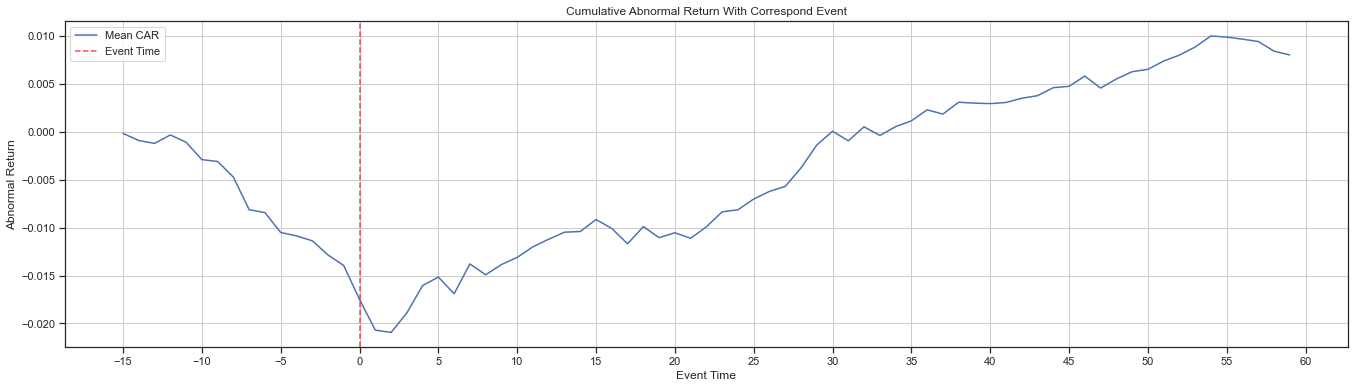

In [191]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Cumulative Abnormal Return With Correspond Event')
Cols   = Plot_Df.columns

# for col in Cols :
#     ax.plot(Plot_Df.index , np.cumsum(Plot_Df[col]),label=str(col),alpha=0.3)

ax.plot(Plot_Df.index , np.cumsum(Plot_Df.mean(axis=1)),label='Mean CAR')
ax.axvline(0,label='Event Time',color='red',linestyle='--',alpha=0.7)
ax.set_ylabel('Abnormal Return')
ax.set_xlabel('Event Time')

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

ax.legend()
ax.grid()
plt.show()
